In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
import pandas as pd
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

file = h5py.File(f'C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\dataset\\QuickDrawImages19.h5','r')

mapping = ['marker', 'matches', 'megaphone', 'mermaid', 'microphone', 'microwave', 'monkey', 'moon', 'mosquito', 'motorbike','hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket']

images = np.array(file['images'])
labels = np.array(file['targets'])
labels = labels-min(labels) #make labels start from zero

file2 = h5py.File(f'C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\dataset\\QuickDrawImages16.h5','r')
images2 = np.array(file2['images'])
labels2 = np.array(file2['targets'])
labels2 = labels2-min(labels2)+10

images = np.concatenate((images,images2),axis=0)
labels = np.concatenate((labels,labels2),axis=0)

images = np.expand_dims(images,axis=3)
targets = []
for label in labels:
    onehot = np.zeros(20)
    onehot[label] = 1
    targets.append(onehot)
    
targets = np.array(targets)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

X_train, X_test, y_train, y_test = train_test_split(images,targets,test_size=.1,shuffle=True)

train_datagen.fit(X_train)
test_datagen.fit(X_test)

In [3]:
def get_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(96,96,1)),
        tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='valid'),
        tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='valid'),
        tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='valid'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128,activation="relu"),
        tf.keras.layers.Dense(20,activation="softmax") #probability distribution output
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics="accuracy"
    )
    model.build()
    return model

In [11]:
model = get_model()

In [5]:
model.fit(train_datagen.flow(X_train, y_train, batch_size=32,subset='training'),
          epochs=30,
          validation_data=train_datagen.flow(X_train, y_train,batch_size=8, subset='validation'),
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_accuracy', 
                  patience=3,
                  min_delta=0.0001,
                  factor=0.25,
                  min_lr=0.000001
                ),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy', 
                  patience=6, 
                  verbose=2,
                  mode='max',
                  restore_best_weights=True
                ),
              tf.keras.callbacks.ModelCheckpoint(
                     filepath='C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', mode="max",
                     save_weights_only=True, save_best_only=True
                )   
          ])

Epoch 1/30


4499/4500 [============================>.] - ETA: 0s - loss: 1.1410 - accuracy: 0.6658
Epoch 1: val_accuracy improved from -inf to 0.80514, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
4500/4500 [==============================] - 268s 59ms/step - loss: 1.1408 - accuracy: 0.6658 - val_loss: 0.6861 - val_accuracy: 0.8051 - lr: 0.0010
Epoch 2/30
4500/4500 [==============================] - ETA: 0s - loss: 0.8091 - accuracy: 0.7700
Epoch 2: val_accuracy improved from 0.80514 to 0.83081, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
4500/4500 [==============================] - 264s 59ms/step - loss: 0.8091 - accuracy: 0.7700 - val_loss: 0.6150 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 3/30
4500/4500 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.7942
Epoch 3: val_accuracy improved from 0.83081 to 0.84336, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-de

KeyboardInterrupt: 

In [12]:
model.load_weights('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5')

In [13]:
model.evaluate(test_datagen.flow(X_test, y_test))

625/625 [==============================] - 10s 16ms/step - loss: 0.3758 - accuracy: 0.8968


[0.37582430243492126, 0.8968499898910522]

In [16]:
model.save('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_897testacc.h5')

c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 139ms/step
TRUE: mermaid,PREDICT: mermaid, 84.77%


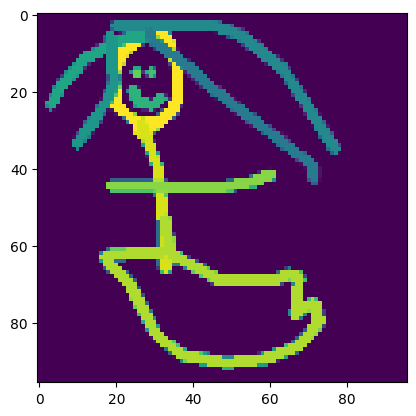

1/1 [==============================] - 0s 34ms/step
TRUE: jacket,PREDICT: jacket, 99.58%


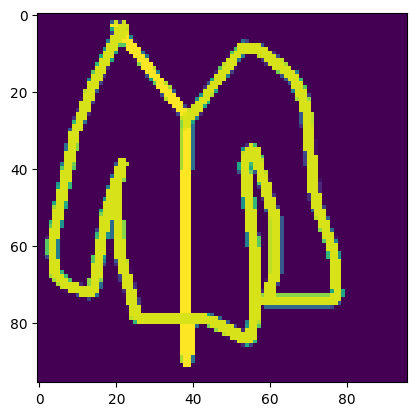

1/1 [==============================] - 0s 42ms/step
TRUE: moon,PREDICT: moon, 100.0%


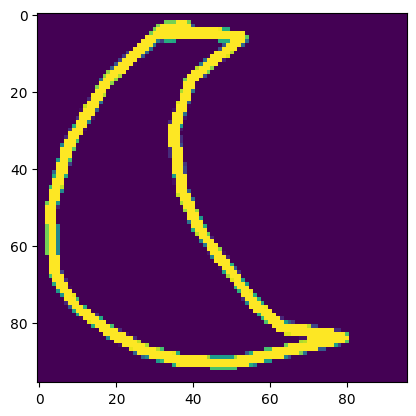

1/1 [==============================] - 0s 34ms/step
TRUE: jacket,PREDICT: jacket, 99.85%


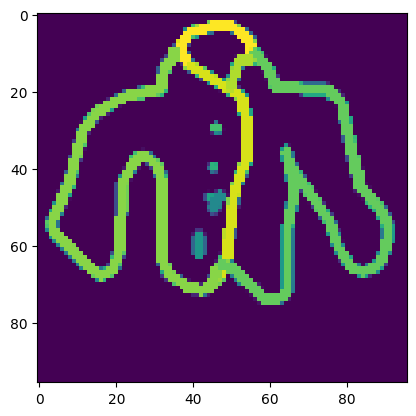

1/1 [==============================] - 0s 33ms/step
TRUE: marker,PREDICT: marker, 97.08%


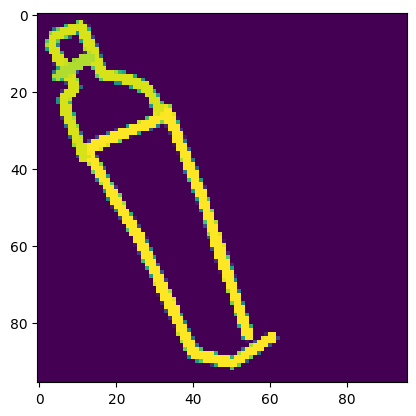

1/1 [==============================] - 0s 37ms/step
TRUE: motorbike,PREDICT: motorbike, 99.82%


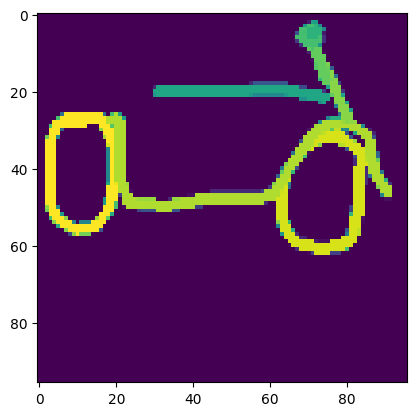

1/1 [==============================] - 0s 37ms/step
TRUE: megaphone,PREDICT: megaphone, 55.16%


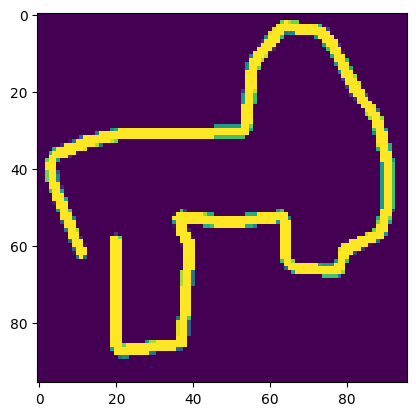

1/1 [==============================] - 0s 34ms/step
TRUE: monkey,PREDICT: monkey, 49.13%


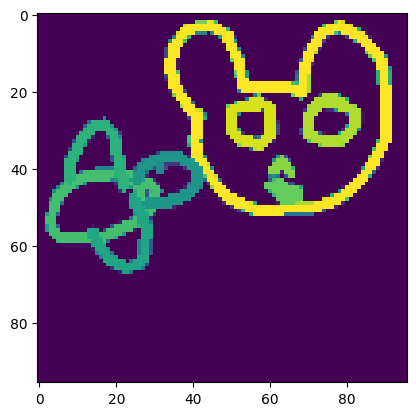

1/1 [==============================] - 0s 31ms/step
TRUE: house_plant,PREDICT: house_plant, 99.62%


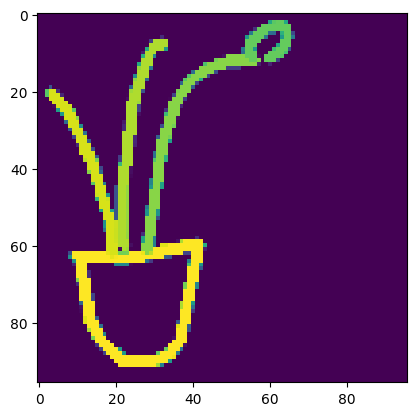

1/1 [==============================] - 0s 32ms/step
TRUE: marker,PREDICT: marker, 64.82%


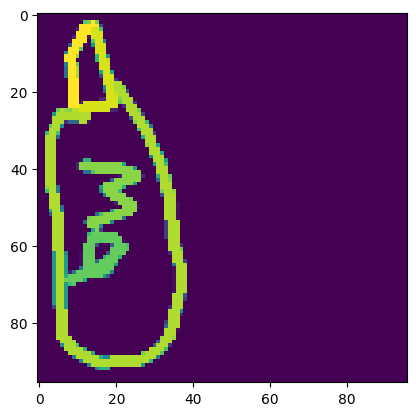

In [9]:
from matplotlib import pyplot as plt


for i in range(10):
    img = X_test[i]
    label = np.argmax(y_test[i])
    pred = model.predict(test_datagen.flow(np.array([img])))[0]
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    plt.imshow(img, interpolation='nearest')
    plt.show()
